# Bacterial activity quantification

In this notebook, we seek robust methods for quantifying bacterial activity in droplets.

We have already tried PIV before, which does not yield satisfactory results due to its self-inconsistency upon window size (and mask) choice. The accuracy of PIV at low bacterial concentration is also doubted. 

Here, we use particle tracking based methods to quantify bacterial activity. Specifically, I will use Cristian's experiment, where he put melamine particles in the surroundings of bacterial droplets as an activity indicator, to compare PIV and PTV. I also want to be more ambitious, to do some experiment with fluorescent tracer particles inside bacterial droplets, to obtain local flow velocity. Dynamic differential microscopy may also be a candidate method.

In [97]:
from deLib import droplet_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from myImageLib import readdata
from pivLib import piv_data, read_piv
from skimage import io
import os
from IPython.display import clear_output
import ipywidgets as widgets
import matplotlib
%matplotlib widget
# matplotlib.use("nbagg")
import cv2
from scipy.optimize import curve_fit
from pivLib import PIV

## 1 PIV and PTV on external tracers (Cristian's experiment)

### 1.1 Look at particle tracking data first
Use frame 2001-2010.

In [3]:
folder = "/home/zhengyang/Documents/test_piv/"
l = readdata(folder, "tif")[2000:2009]
di

In [29]:
# load images and create frame number list
img_stack = {}
for num, i in l.iterrows():
    img_stack[num] = io.imread(i.Dir)

plt.ioff()
fig = plt.figure()
plt.ion()
im = plt.imshow(img_stack[l.index[0]], cmap="gray")
def update(change):
    im.set_data(img_stack[change['new']])
    fig.canvas.draw_idle()
slider = widgets.IntSlider(value=l.index[0], min=l.index[0], max=l.index[-1])
slider.observe(update, names='value')
widgets.VBox([slider, fig.canvas])

**We first use TrackMate to detect tracers**

In [16]:
tracer = pd.read_csv(os.path.join(folder, "particle-track.csv"), usecols=[2,4,5,7], names=["particle", "x", "y", "frame"], skiprows=4)

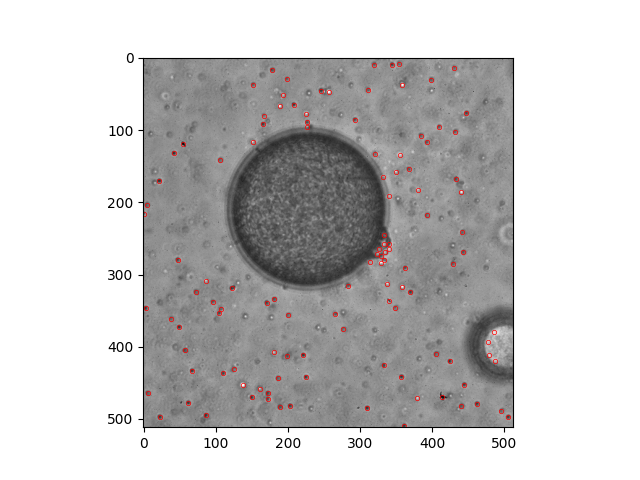

In [27]:
plt.figure()
img = io.imread(l.iloc[0].Dir)
plt.imshow(img, cmap="gray")
plt.scatter(tracer.loc[tracer.frame==0].x, tracer.loc[tracer.frame==0].y, fc=(0,0,0,0), ec="red", s=10, lw=.5)

**Then compute velocity in Cartesian coordinates.**

In [31]:
t1 = tracer.assign(vx=0, vy=0)

for p, t in tracer.groupby("particle"):
    t1.at[t.index, "vx"] = t.x.diff()
    t1.at[t.index, "vy"] = t.y.diff()

# plot velocity field
t2 = t1.loc[t1.frame==5]
plt.figure()
plt.imshow(img, cmap="gray")
plt.quiver(t2.x, t2.y, t2.vx, t2.vy)

**Some velocities near the droplet appear anomalously large, let's look at the histogram.**

<AxesSubplot:>

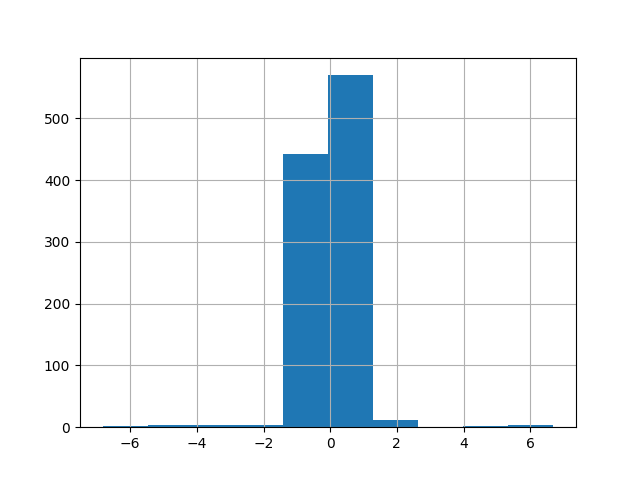

In [47]:
plt.figure()
t1.vx.hist()

**Considering that the large velocity only makes up a tiny fraction, we carry on with these velocities. Now convert velocity to polar coordinates.**

In [57]:
center = (229, 210)
radius = 110

In [55]:
theta = np.arctan(t1.y-center[1]/t1.x-center[0])
r = ((t1.x - center[0]) ** 2 + (t1.y - center[1]) ** 2) ** 0.5 
t1 = t1.assign(vr=t1.vx*np.cos(theta)+t1.vy*np.sin(theta), vtheta=-t1.vx*np.sin(theta)+t1.vy*np.cos(theta), r=r, theta=theta)

**Next, let's compute the azimuthal velocity (vtheta) profile.**

In [67]:
bins = np.linspace(110, 400, 10)
vt_list = []
for i, start in enumerate(bins[:-1]):
    t = t1.loc[(t1.r>=bins[i])&(t1.r<bins[i+1])]
    vt_list.append(t.vtheta.abs().mean())

Text(0, 0.5, '$<v_\\theta>$')

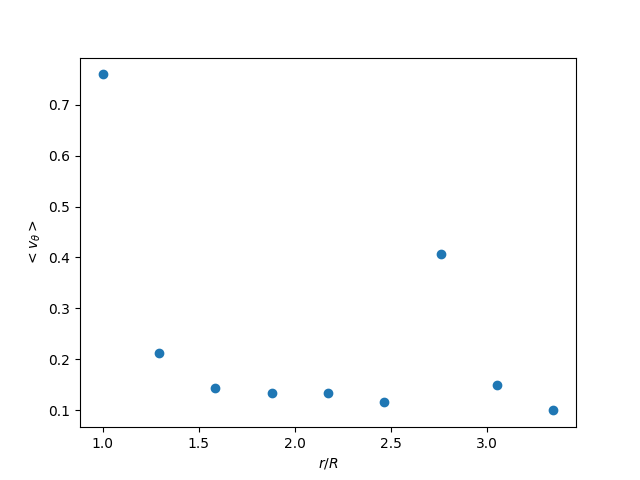

In [70]:
plt.figure()
plt.scatter(bins[:-1]/radius, vt_list)
plt.xlabel("$r/R$")
plt.ylabel("$<v_\\theta>$")

**Also look at a longer track (frame 1400-6593)**

In [170]:
tracer = pd.read_csv(os.path.join(folder, "particle-track.csv"), usecols=[2,4,5,7], names=["particle", "x", "y", "frame"], skiprows=4)
t1 = tracer.assign(vx=0, vy=0)

for p, t in tracer.groupby("particle"):
    t1.at[t.index, "vx"] = t.x.diff()
    t1.at[t.index, "vy"] = t.y.diff()

center = (229, 210)
radius = 110

theta = np.arctan(t1.y-center[1]/t1.x-center[0])
r = ((t1.x - center[0]) ** 2 + (t1.y - center[1]) ** 2) ** 0.5 
t1 = t1.assign(vr=t1.vx*np.cos(theta)+t1.vy*np.sin(theta), vtheta=-t1.vx*np.sin(theta)+t1.vy*np.cos(theta), r=r, theta=theta)

In [171]:
bins = np.linspace(110, 400, 10)
vt_list = []
for i, start in enumerate(bins[:-1]):
    t = t1.loc[(t1.r>=bins[i])&(t1.r<bins[i+1])]
    vt_list.append(t.vtheta.abs().mean())

Text(0, 0.5, '$<v_\\theta>$')

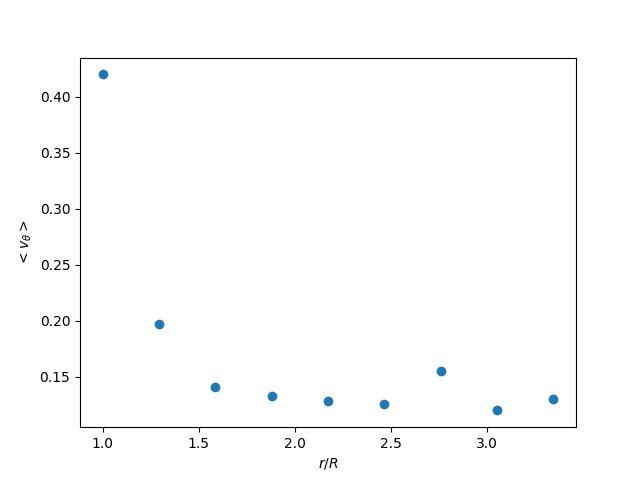

In [172]:
plt.figure()
plt.scatter(bins[:-1]/radius, vt_list)
plt.xlabel("$r/R$")
plt.ylabel("$<v_\\theta>$")

In [174]:
data = pd.DataFrame({"rr": (bins[:-1]+bins[1:])/2/radius, "vtheta": vt_list})
data.to_csv("/home/zhengyang/Documents/vp-ptv.csv")

Including more data improves the quality of azimuthal velocity profile. The bump between 2.5 and 3 gets smaller. The scale of external flow field is 0.4 px/frame, corresponding to 2 um/s.

### 1.2 Compute PIV data

**First get raw PIV data**

In [98]:
l = readdata(folder, "tif")[1399:]

In [117]:
save_folder = "/home/zhengyang/Documents/piv/"

In [148]:
for i0, i1 in zip(l.iloc[::2].iterrows(), l.iloc[1::2].iterrows()):
    print("{0}-{1}".format(i0[1].Name, i1[1].Name), end="\r")
    I0 = io.imread(i0[1].Dir)
    I1 = io.imread(i1[1].Dir)
    x, y, u, v = PIV(I0, I1, 80, 40, 0.02)
    data = pd.DataFrame({"x": x.flatten(), "y": y.flatten(), "u": u.flatten(), "v": v.flatten()})
    data.to_csv(os.path.join(save_folder, "{0}-{1}.csv".format(i0[1].Name, i1[1].Name)), index=False)

**Convert u, v to polar velocity**

In [167]:
# piv_folder = save_folder
piv_folder = "/home/zhengyang/Documents/piv_w80"
lpiv = readdata(piv_folder, "csv")
profile_list = []
for num, i in lpiv.iterrows():
    print(num, end="\r")
    pivData = pd.read_csv(i.Dir)
    pivData.assign(r=0, theta=0, vr=0, vtheta=0)
    pivData.at[:, "r"] = ((pivData.x - center[0]) ** 2 + (pivData.y - center[1]) ** 2) ** 0.5
    pivData.at[:, "theta"] = np.arctan(pivData.y-center[1]/pivData.x-center[0])
    pivData.at[:, "vr"] = pivData.u*np.cos(pivData.theta)+pivData.v*np.sin(pivData.theta)
    pivData.at[:, "vtheta"] = -pivData.u*np.sin(pivData.theta)+pivData.v*np.cos(pivData.theta)
    
    bins = np.linspace(110, 400, 10)
    vt_list = []
    for i, start in enumerate(bins[:-1]):
        t = pivData.loc[(pivData.r>=bins[i])&(pivData.r<bins[i+1])]
        vt_list.append(t.vtheta.pow(2).mean() ** 0.5)
    profile = np.array(vt_list)
    profile_list.append(profile)
vp = np.stack(profile_list).mean(axis=0)

In [153]:
vp = np.stack(profile_list).mean(axis=0)

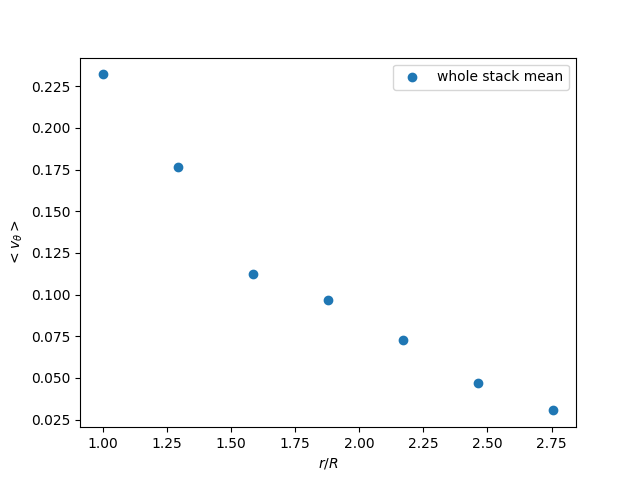

In [168]:
plt.figure()
plt.scatter(bins[:-1]/radius, vp*0.1, label="whole stack mean")
# plt.scatter(bins[:-1]/radius, profile*0.1, label="last frame")
plt.xlabel("$r/R$")
plt.ylabel("$<v_\\theta>$")
plt.legend()

In [175]:
data = pd.DataFrame({"rr": (bins[:-1]+bins[1:])/2/radius, "vtheta": vp*0.1})
data.to_csv("/home/zhengyang/Documents/vp-w80.csv")

The azimuthal velocity profiles from PTV and PIV show qualitatively similar trend. Quantitatively, PTV profile is greater than the PIV one, by a factor of ~2. We investigate this discrepancy by examine the PIV quality. First, I make the overlay image sequence.

In [155]:
l = readdata(folder, "tif")[1399:]
di = droplet_image(l, fps=50, mpp=0.11)
di.piv_overlay_fixed(save_folder, "/home/zhengyang/Documents/overlay/")

The overlap images show qualitative agreement between PIV results and actual particle motions, near the spot with particles. In a relatively sparse region, however, the velocities are very small. This can potentially lead to smaller average velocity. Having no particle in an interrogation window is also not recommended in a PIV analysis. Therefore, I increase the window size from 20 to 60. This time, the velocity is closer to that from PTV, except the first point at r/R=1. After inspecting the overlay videos, I think this is due to the droplet boundary. Since it's mostly prominent image feature (the circular boundary) remains stationary forever, it can drag the PIV velocity to lower than the real velocity. 

Below, we summarize the azimuthal velocity profile measured using PTV and PIV at various window size (20, 60, 80).

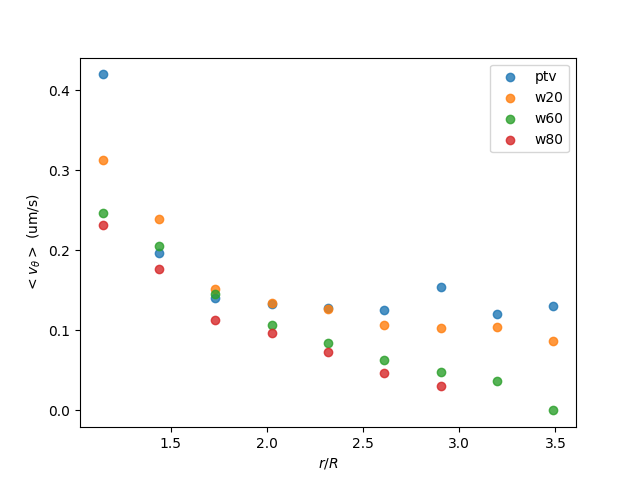

In [178]:
datakw = ["ptv", "w20", "w60", "w80"]

plt.figure()
for kw in datakw:
    vp = pd.read_csv("/home/zhengyang/Documents/vp-{}.csv".format(kw))
    plt.scatter(vp.rr, vp.vtheta, label=kw, alpha=.8)
plt.xlabel("$r/R$")
plt.ylabel("$<v_\\theta>$ (um/s)")
plt.legend()

**Apart from the first point, PTV and PIV20 show pretty good agreement.**

Fit PTV profile with inverse quadratic.

Text(0, 0.5, '$<v_\\theta>$')

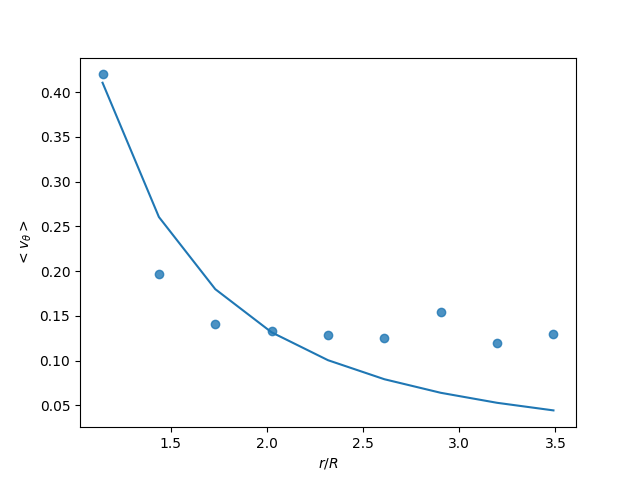

In [199]:
def vp_fit(x, a):
    return a / (x) ** 2

vp = pd.read_csv("/home/zhengyang/Documents/vp-ptv.csv")
x = vp.rr
y = vp.vtheta
popt, pcov = curve_fit(vp_fit, x, y)
plt.figure()
plt.scatter(x, y, alpha=.8)
plt.plot(x, vp_fit(x, *popt))
# plt.ylim([0, 1])
plt.xlabel("$r/R$")
plt.ylabel("$<v_\\theta>$")

## 2 PIV on internal bacteria

Is there a robust correlation between external and internal velocity field? Let's look at the full profile from the droplet center for PIV20.

In [200]:
piv_folder = "/home/zhengyang/Documents/piv_w20"
lpiv = readdata(piv_folder, "csv")
profile_list = []
for num, i in lpiv.iterrows():
    print(num, end="\r")
    pivData = pd.read_csv(i.Dir)
    pivData.assign(r=0, theta=0, vr=0, vtheta=0)
    pivData.at[:, "r"] = ((pivData.x - center[0]) ** 2 + (pivData.y - center[1]) ** 2) ** 0.5
    pivData.at[:, "theta"] = np.arctan(pivData.y-center[1]/pivData.x-center[0])
    pivData.at[:, "vr"] = pivData.u*np.cos(pivData.theta)+pivData.v*np.sin(pivData.theta)
    pivData.at[:, "vtheta"] = -pivData.u*np.sin(pivData.theta)+pivData.v*np.cos(pivData.theta)
    
    bins = np.linspace(0, 400, 14)
    vt_list = []
    for i, start in enumerate(bins[:-1]):
        t = pivData.loc[(pivData.r>=bins[i])&(pivData.r<bins[i+1])]
        vt_list.append(t.vtheta.pow(2).mean() ** 0.5)
    profile = np.array(vt_list)
    profile_list.append(profile)
vp = np.stack(profile_list).mean(axis=0)

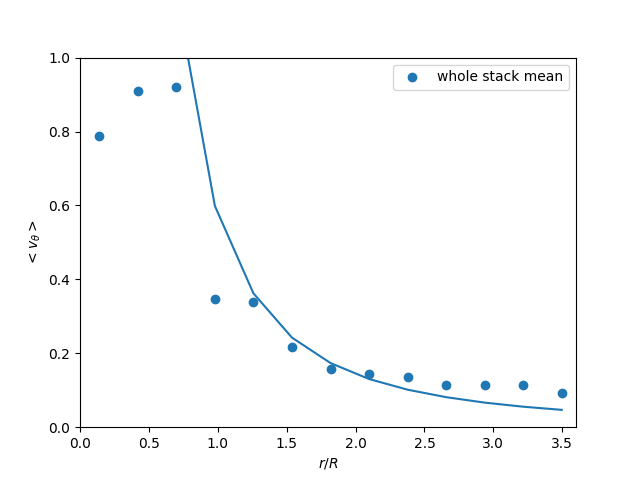

In [202]:
plt.figure()
plt.scatter((bins[:-1]+bins[1:])/2/radius, vp*0.11, label="whole stack mean")
# plt.scatter(bins[:-1]/radius, profile*0.1, label="last frame")
plt.xlabel("$r/R$")
plt.ylabel("$<v_\\theta>$")
plt.legend()
plt.xlim([0, 3.6])
plt.ylim([0, 1])

# fit?
def vp_fit(x, a):
    return a / (x) ** 2

x = (bins[:-1]+bins[1:])/2/radius
y = vp*0.11
popt, pcov = curve_fit(vp_fit, x[4:], y[4:])
plt.plot(x, vp_fit(x, *popt))

In [188]:
popt

array([0.16489623])